# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 1:
In this question we train a linearly separable data with multi layer perceptron

### import libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns

### check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### create data

In [3]:
x, y = datasets.make_blobs(n_samples=200, centers=[(-1, -1), (1, 1)], cluster_std=0.5)
# convert to the torch tensor
x = torch.tensor(x, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.float32, device=device)

### plot data

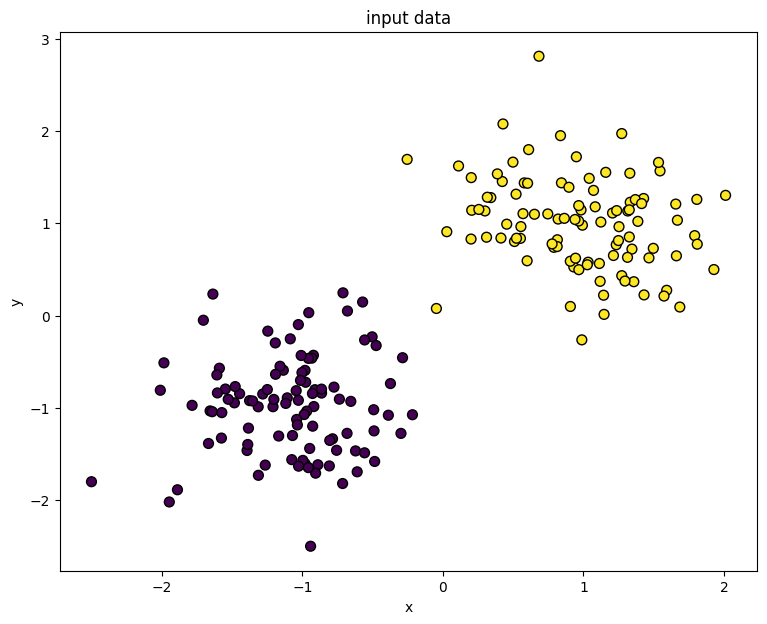

In [5]:
plt.figure(figsize=(9, 7))
plt.scatter(x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), c=y.cpu().numpy(), edgecolors='k', marker='o', s=50)
plt.title("input data")
plt.xlabel('x')
plt.ylabel('y')
plt.show()